In [1]:
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time
# set data file path
data_file_name = '../data/crimes-2001-to-present.snappy.parq'
print('Loading data file: {}'.format(data_file_name))

# load crimes parquet data into dask data frame
crimes = dd.read_parquet(data_file_name, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading data file: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 15.1 s


In [4]:
%%time
# log records count and data frame/partitions stats
print('Chicago Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Chicago Crime data stats:
---------------------------------------
6,343,964 total records in 1 partitions
DataFrame size: 57,095,676
Wall time: 2.93 ms


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude
npartitions=1,,,,,,,,,
2001-01-01 00:00:00,object,object,object,object,float64,bool,bool,float64,float64
2017-06-15 23:59:00,...,...,...,...,...,...,...,...,...


In [6]:
%%time
# preview crimes data with Date index
crimes.head(5)

Wall time: 1.95 ms


,Block,PrimaryType,Description,LocationDescription,CommunityArea,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,,
2001-09-15 02:00:00,013XX W POLK ST,BATTERY,SIMPLE,STREET,NaN,False,False,NaN,NaN
2001-11-02 18:30:00,002XX W CONGRESS PW,THEFT,OVER $500,OTHER,NaN,False,False,NaN,NaN
2001-12-15 02:00:00,011XX N STATE ST,BATTERY,SIMPLE,STREET,NaN,False,False,NaN,NaN
2002-09-26 13:30:00,034XX W 79TH ST,BATTERY,SIMPLE,STREET,70.0,False,False,NaN,NaN
2002-10-01 19:00:00,022XX W NORTH AVE,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,24.0,False,False,NaN,NaN


In [7]:
%%time

# get crime types
crime_types = crimes[['PrimaryType']]

# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']]\
.groupby('PrimaryType').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic, and totals)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                     Arrest  Domestic    Total
PrimaryType                                                   
THEFT                              159868.0   30461.0  1322117
BATTERY                            266032.0  488841.0  1160354
CRIMINAL DAMAGE                     51858.0   54703.0   728751
NARCOTICS                          680931.0     243.0   685183
OTHER OFFENSE                       69425.0  114427.0   393899
ASSAULT                             91871.0   84316.0   389711
BURGLARY                            21240.0    2427.0   369599
MOTOR VEHICLE THEFT                 27588.0    1112.0   298840
ROBBERY                             23472.0    3854.0   240230
DECEPTIVE PRACTICE                  42505.0    2737.0   232992
CRIMINAL TRESPASS                  136053.0    5760.0   183442
PROSTITUTION                        65934.0       6.0    66194
WEAPONS VIOLATION                   50773.0     223.0    63144
PUBLIC PEACE VIOLATION              29407.0    2136.0  

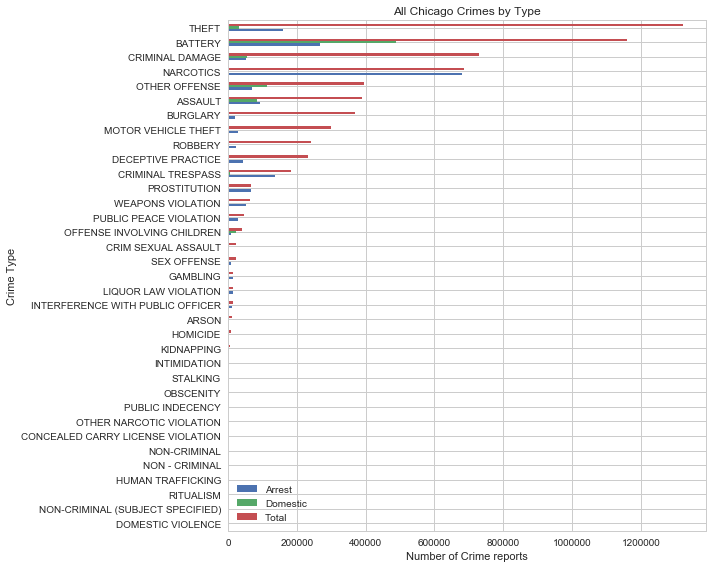

In [8]:
# plot crimes by primary type counts
crime_type_counts.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('All Chicago Crimes by Type')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

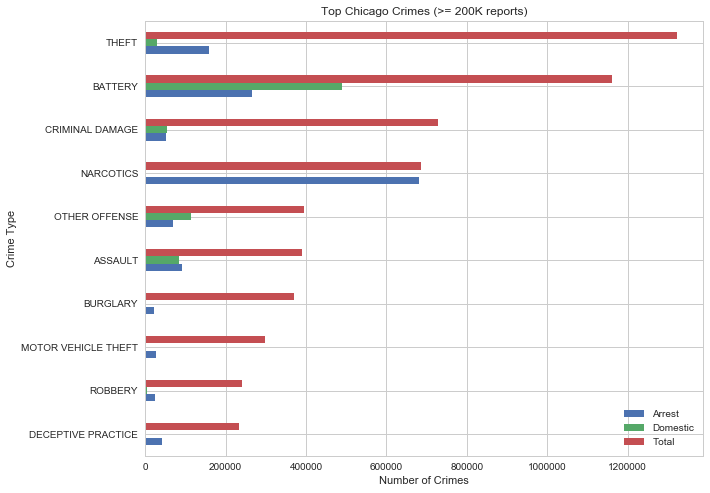

In [9]:
# plot top crimes (>-= 200,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('Top Chicago Crimes (>= 200K reports)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')

In [10]:
%%time
print('\nParsing All Crimes...')

# get monthly total crime counts
monthly_crime = crime_types.resample('M').count().compute()

# print monthly total crime stats
print('---------------------------------------')
print(monthly_crime.head())
print('...\nTotal Crime records: {:,}'.format(len(crimes)))
print('Total Months: {:,}'.format(monthly_crime.size))

# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print('\nArrests:')
print('---------------------------------------')
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print('\nDomestic:')
print('---------------------------------------')
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))


Parsing All Crimes...
---------------------------------------
            PrimaryType
2001-01-31        38008
2001-02-28        33711
2001-03-31        40418
2001-04-30        40030
2001-05-31        41734
...
Total Crime records: 6,343,964
Total Months: 198

Arrests:
---------------------------------------
Date
2002-11-05 16:40:00    True
2006-10-17 13:05:00    True
2005-10-01 09:00:00    True
2006-02-23 19:06:20    True
2009-12-08 10:45:00    True
Name: Arrest, dtype: bool
...
Total Arrests: 1,785,102

Domestic:
---------------------------------------
Date
2016-01-26 15:00:00    True
2017-01-09 07:15:00    True
2016-04-04 01:00:00    True
2016-05-28 13:00:00    True
2016-04-12 03:30:00    True
Name: Domestic, dtype: bool
...
Total Domestic: 822,752
Wall time: 5.96 s


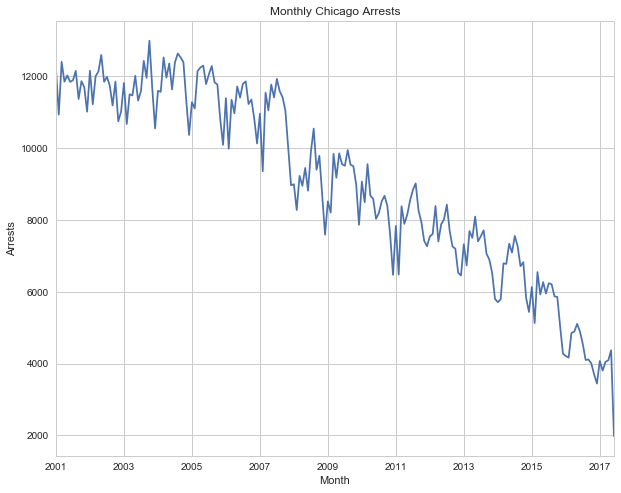

In [11]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(figsize=(10,8))
plt.title('Monthly Chicago Arrests')
plt.xlabel('Month')
plt.ylabel('Arrests')
plt.show()

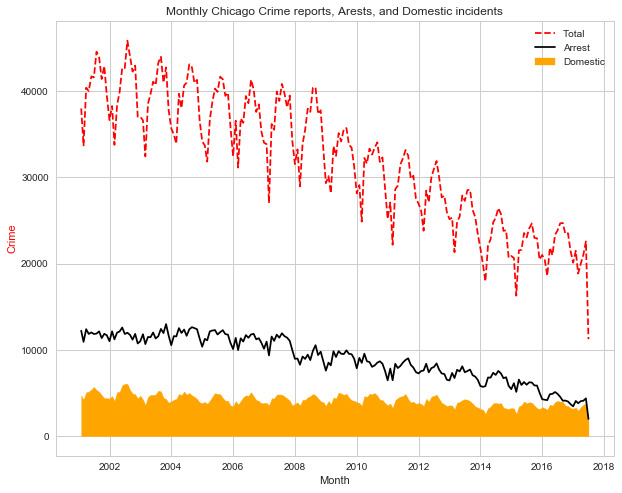

In [12]:
# get monthly domestic crimes
monthly_domestic = domestic.resample('M').sum().compute()

# plot monthly crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(monthly_crime.index, monthly_crime, '--', label='Total', color='r')
ax.plot(monthly_arrests.index, monthly_arrests, color='black', zorder=10)
ax.fill_between(monthly_domestic.index, monthly_domestic, \
                label='Domestic', color='orange')
ax.set_xlabel('Month')
ax.set_ylabel('Crime', color='r')
ax.legend(loc='upper right')
plt.title('Monthly Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

In [13]:
# get top crime types
top_crime_types = crime_type_counts[crime_type_counts['Total'] >= 200000]\
.sort_values(by='Total', ascending=False)
top_crime_types.head(10)

,Arrest,Domestic,Total
PrimaryType,,,
THEFT,159868.0,30461.0,1322117
BATTERY,266032.0,488841.0,1160354
CRIMINAL DAMAGE,51858.0,54703.0,728751
NARCOTICS,680931.0,243.0,685183
OTHER OFFENSE,69425.0,114427.0,393899
ASSAULT,91871.0,84316.0,389711
BURGLARY,21240.0,2427.0,369599
MOTOR VEHICLE THEFT,27588.0,1112.0,298840
ROBBERY,23472.0,3854.0,240230


In [14]:
%%time
print('Getting Top Crimes by Month...')

# get top crimes stats
# TODO: use isin and index by primary type to speed up this query?
top_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                         (crime_types['PrimaryType']=='BATTERY') | \
                         (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                         (crime_types['PrimaryType']=='NARCOTICS') | \
                         (crime_types['PrimaryType']=='OTHER OFFENSE') | \
                         (crime_types['PrimaryType']=='ASSAULT') | \
                         (crime_types['PrimaryType']=='BURGLARY') | \
                         (crime_types['PrimaryType']=='MOTOR VEHICLE THEFT') | \
                         (crime_types['PrimaryType']=='ROBBERY') | \
                         (crime_types['PrimaryType']=='DECEPTIVE PRACTICE')]
#print(top_crimes.head(10))

# group top crimes by month and crime type
crimes_groupby = top_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_crime_data.head(10))
print('...')

# unstack top crimes type group for series plotting
top_crime_data = top_crime_data.unstack()
print(top_crime_data.head(10))
print('...')

Getting Top Crimes by Month...
Date        PrimaryType        
2001-01-31  ASSAULT                2122
            BATTERY                6520
            BURGLARY               1932
            CRIMINAL DAMAGE        3960
            DECEPTIVE PRACTICE     1382
            MOTOR VEHICLE THEFT    2092
            NARCOTICS              4708
            OTHER OFFENSE          2797
            ROBBERY                1396
            THEFT                  7852
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  BURGLARY  CRIMINAL DAMAGE  DECEPTIVE PRACTICE  \
Date                                                                           
2001-01-31      2122     6520      1932             3960                1382   
2001-02-28      2028     6040      1664             3656                1155   
2001-03-31      2822     7652      1825             4602                1303   
2001-04-30      2745     8323      1927             4910                1192   
2001-05-31      2900     88

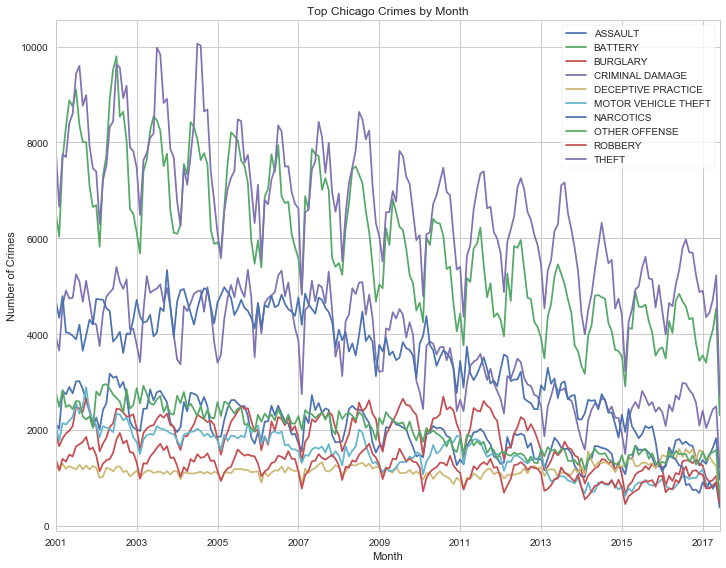

In [15]:
# plot top crimes data by week
top_crime_data.plot(figsize=(10,8))
plt.legend(loc='upper right', frameon=True)
plt.title('Top Chicago Crimes by Month')
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()

In [16]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       1678137
RESIDENCE    1076137
APARTMENT     648079
SIDEWALK      632697
OTHER         239651
Name: Total, dtype: int64
...
Total Locations: 173


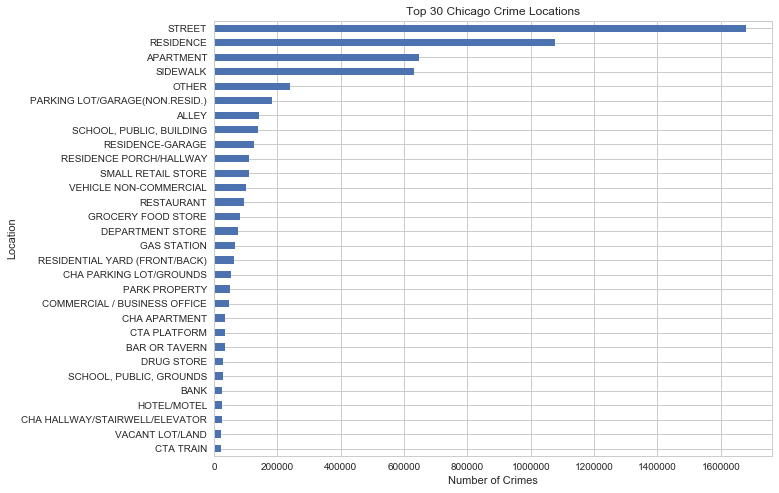

In [17]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('Top 30 Chicago Crime Locations')
plt.xlabel('Number of Crimes')
plt.ylabel('Location')
plt.show()

In [18]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName        Side   Total
25             25           Austin   West Side  367329
8               8  Near North Side     Central  189648
43             43      South Shore  South Side  187196
23             23    Humboldt Park   West Side  181518
24             24        West Town   West Side  170072
...
Total Communities: 77


In [19]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,367329
Near North Side,189648
South Shore,187196
Humboldt Park,181518
West Town,170072


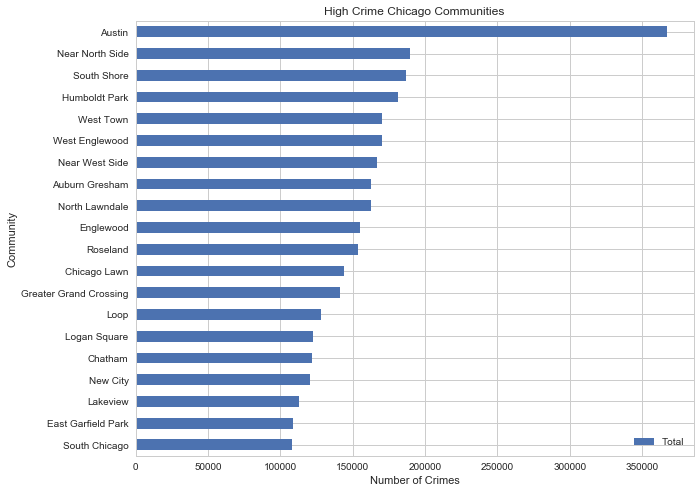

In [20]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('High Crime Chicago Communities')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
plt.show()

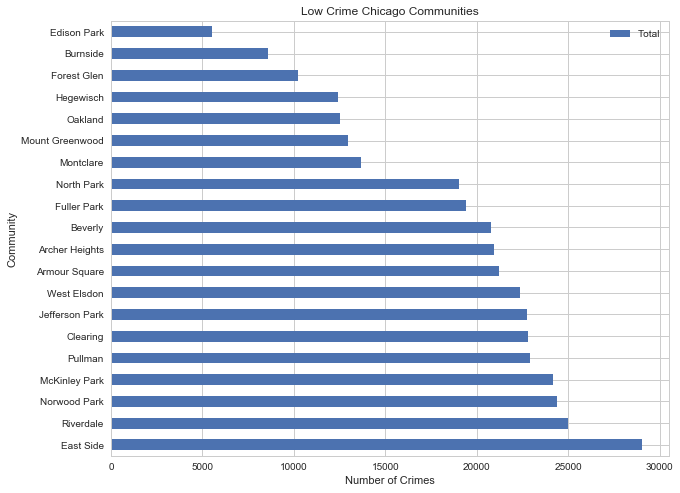

In [21]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False)\
.plot(kind='barh', figsize=(10,8))
plt.title('Low Crime Chicago Communities')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
plt.show()

In [22]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum()\
.drop('CommunityArea', axis=1) # denotes column
crime_by_side

,Total
Side,
Central,361715
Far North Side,504346
Far Southeast Side,673912
Far Southwest Side,362952
North Side,413115
Northwest Side,330147
South Side,787506
Southwest Side,881314
West Side,1414440


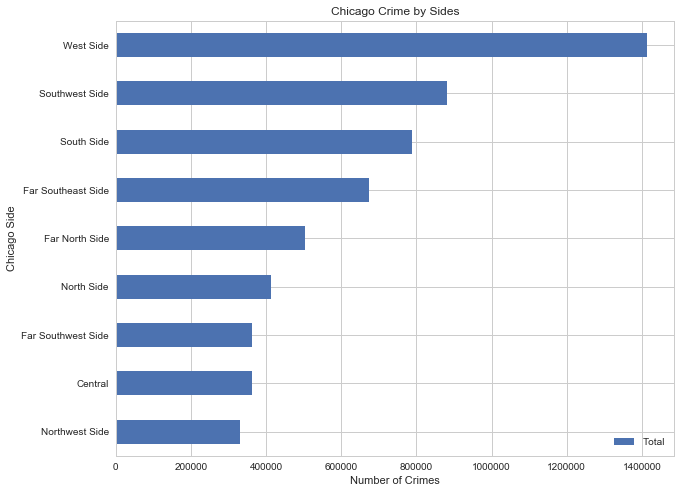

In [23]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('Chicago Crime by Sides')
plt.xlabel('Number of Crimes')
plt.ylabel('Chicago Side')
plt.show()